In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt


In [2]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm import tqdm
import math

import seaborn as sns
%matplotlib inline

import gc

In [3]:
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
print(train_df.shape)
print(test_df.shape)
display(train_df.head())

(1306122, 3)
(375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Check for data imbalance

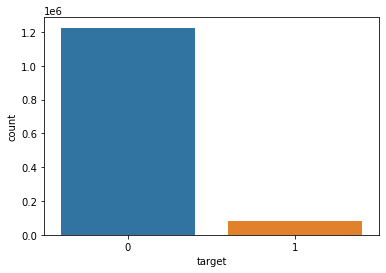

In [4]:
sns.countplot(train_df.target)

Check for missing values

In [5]:
train_df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [6]:
test_df.isna().sum()

qid              0
question_text    0
dtype: int64

Do the following in the next steps:

* Split the train into train and validation sets. We will not do cross valdiation as it is time consuming
* No missing values identified, if any, replace them with 'na'
* Tokenize the `text` column and convert them to vector sequences
* Pad or truncate the sequences as required - truncation happens when sequence length exceeds `max_len` and if less, they will be padded

In [7]:
%%time
# split into train and validation sets

train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=2020)

# some config values for tokenization and vector sequences

max_len = 100        # max number of words in the question that will be used
max_features = 50000 # max number of features or unique words we will use from the entire corpus (the same as number of rows in the embedding matrix)
embed_size = 300     # size of each embedding or word vector

CPU times: user 470 ms, sys: 32.1 ms, total: 502 ms
Wall time: 511 ms


In [ ]:
%%time
# substitute missing values in text
train_X = train_df['question_text'].fillna("_na_")
valid_X = valid_df['question_text'].fillna("_na_")
test_X = test_df['question_text'].fillna("_na_")

# tokenize the sentences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = max_features)

# fit on train_X. fit_on_texts() expects a list of text as input
tokenizer.fit_on_texts(train_X.values.tolist())

# use fit_to_sequences method to encode the tokens or words into interger sequences
train_X = tokenizer.texts_to_sequences(train_X.values)
valid_X = tokenizer.texts_to_sequences(valid_X.values)
test_X = tokenizer.texts_to_sequences(test_X.values)

# pad the sentences, according to the max_len
from keras.preprocessing.sequence import pad_sequences

train_X = pad_sequences(train_X, maxlen = max_len)
valid_X = pad_sequences(valid_X, maxlen = max_len)
test_X = pad_sequences(test_X, maxlen = max_len)

# store the target values
train_y = train_df['target'].values
valid_y = valid_df['target'].values

### Without using any of the trained embeddings provided:
We will learn the embeddings from scratch without using any of the trained embeddings as the first step. For this we will train a Bidirectional GRU model. We will use the CUDA based NN model from Nvidia known as th CuDNNGRU, which is GPU based.

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, CuDNNGRU, Dense, Dropout, LSTM, Conv1D, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
# tensorflow version check
import tensorflow as tf
print('tensor flow version in use: ', tf.__version__)

Using the CuDNNGRU is not importable as it seems to have been deprecated in recent versions of TF and I keep getting error 'ModuleNotFoundError: No module named 'tensorflow.contrib'', this is because this model is removed in the current version.

The better way is to simply use the GRU and or LSTM as it is, which will default to `CuDNNGRU` and `CuDNNLSTM`, if certain conditions are met. Refer [here](https://stackoverflow.com/questions/60468385/is-there-cudnnlstm-or-cudnngru-alternative-in-tensorflow-2-0)

Refer to other links on how to import a `GRU` model:
1. https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNGRU
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = embed_size, input_length = max_len)) # input_shape is optional
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Train the model on the given train split and monitor the metric on the validation set. Run for 2 epochs for now. Changing the epochs, batch_size, model parameters could give a better model

In [ ]:
%%time
# train the model
model.fit(train_X, train_y, batch_size=512, epochs =2 , validation_data = (valid_X, valid_y))

In [ ]:
import pickle
pickle.dump(model, open('bidirectional_gru_keras_no_pretrain_embed.pkl', 'wb'))

*let's looks at the validation sample predictions and decide the best threshold for `F1` score. The actual values are `0` and `1`. Based on threshold, the predictions will vary.*

Here we are learning embeddings and we don't use any of the pretrained embeddings that have been provided along with the data

In [ ]:
prediction_noembed_val_y = model.predict([valid_X], batch_size=1024, verbose=1)

for thresh in np.arange(0.1, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    score = round(metrics.f1_score(valid_y, (prediction_noembed_val_y > thresh).astype(int)),4)
    print('F1 score at threshold {} is {}'.format(thresh, score))

In [ ]:
# predictions on test(no pretrained embedding in use)
pred_noembed_y = model.predict([test_X], batch_size=1024, verbose=1)

**Clear memory before going to next step**

In [ ]:
del model
gc.collect()

# pause execution for 10s after gc to allow gc to complete
time.sleep(10)

Imported Glove840b300d embeddin file from kaggle

In [8]:
import tqdm

EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'

# fp = open(EMBEDDING_FILE, 'r', encoding='utf8')

# for line in fp:
#     values = line.split()
#     word= values[0]
#     coeff = np.asarray(values[1:], dtype='float32')
#     print(word)
#     print(coeff)
#     break

# fp.close()  

In [ ]:
with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    print(fp.readline())